In [1]:
# Imports

# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from collections import OrderedDict
from PIL import Image

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import transforms # import transformations to use for demo
from torch.utils.data import Dataset, DataLoader 

![image](https://github.com/Lexie88rus/Activation-functions-examples-pytorch/raw/master/assets/blur-blurry-close-up-167259.jpg)

# Extending PyTorch with Custom Activation Functions

## Introduction
Today deep learning is viral and applied to a variety of machine learning problems such as image recognition, speech recognition, machine translation, etc. There is a wide range of highly customizable neural network architectures, which can suit almost any problem when given enough data. Each neural network should be customized to suit the given problem well enough. You have to fine tune the hyperparameters for the network for each task (the learning rate, dropout coefficients, weight decay, etc.) as well as number of hidden layers, number of units in layers. __Choosing the right activation function for each layer is also crucial and may have a significant impact on learning speed.__

## Activation Functions


The [activation function](https://www.analyticsvidhya.com/blog/2017/10/fundamentals-deep-learning-activation-functions-when-to-use-them/) is an essential building block for every neural network. We can choose from a huge list of popular activation functions, which are already implemented in Deep Learning frameworks, like [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks), [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function), [Tanh](https://en.wikipedia.org/wiki/Hyperbolic_function) and many others.

But to create a state of the art model, customized particularly for your task, you may need to use a custom activation function, which is not yet implemented in Deep Learning framework you are using. Activation functions can be roughly classified into the following groups by complexity:

1. Simple activation functions like [SiLU](https://arxiv.org/pdf/1606.08415.pdf), [Inverse square root unit (ISRU)](https://arxiv.org/pdf/1710.09967.pdf). These functions can be easily implemented in any Deep Learning framework.
2. Activation functions with __trainable parameters__ like [SoftExponential](https://arxiv.org/pdf/1602.01321.pdf) or [S-shaped rectified linear activation unit (SReLU)](https://arxiv.org/pdf/1512.07030.pdf). 
3. Activation functions, which are not differentiable at some points and require __custom implementation of backward step__, for example [Bipolar rectified linear unit (BReLU)](https://arxiv.org/pdf/1709.04054.pdf).

In this kernel I will try to cover implementation and demo examples for all of these types of functions using [Fashion MNIST dataset](https://www.kaggle.com/zalando-research/fashionmnist).

## Seeting Up The Demo
Ih this section I will prepare everything for the demonstration:
* Load Fashion MNIST dataset from PyTorch,
* Introduce transformations for Fashion MNIST images using PyTorch,
* Prepare model training procedure.

If you are familiar with PyTorch basics, just skip this part and go straight to implementation of the activation functions.

### Introduce Transformations

The most efficient way to transform the input data is to use buil-in PyTorch transformations:

In [2]:
# Define a transform
transform = transforms.Compose([transforms.ToTensor()])

### Load the Data

To load the data I used standard Dataset and Dataloader classes from PyTorch and [FashionMNIST class code from this kernel](https://www.kaggle.com/arturlacerda/pytorch-conditional-gan):

In [3]:
class FashionMNIST(Dataset):
    '''
    Dataset clas to load Fashion MNIST data from csv.
    Code from original kernel:
    https://www.kaggle.com/arturlacerda/pytorch-conditional-gan
    '''
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('../input/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

# Load the training data for Fashion MNIST
trainset = FashionMNIST(transform=transform)
# Define the dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

### Setup Training Procedure
I wrote a small training procedure, which runs 5 training epochs and prints the loss for each epoch, so we make sure that we are fitting the training set:

In [4]:
def train_model(model):
    '''
    Function trains the model and prints out the training log.
    '''
    #setup training
    
    #define loss function
    criterion = nn.NLLLoss()
    #define learning rate
    learning_rate = 0.003
    #define number of epochs
    epochs = 5
    #initialize optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #run training and print out the loss to make sure that we are actually fitting to the training set
    print('Training the model. Make sure that loss decreases after each epoch.\n')
    for e in range(epochs):
        running_loss = 0
        for images, labels in trainloader:
            images = images.view(images.shape[0], -1)
            log_ps = model(images)
            loss = criterion(log_ps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        else:
            # print out the loss to make sure it is decreasing
            print(f"Training loss: {running_loss}")

## Implementing Simple Activation Functions
The most simple activation functions
* are differentiable and don't need the manual implementation of the backward step,
* don't have any trainable parameters, all their parameters are set in advance.

One of the examples of such simple functions is Sigmoid Linear Unit or just [SiLU](https://arxiv.org/pdf/1606.08415.pdf) also known as Swish-1:

$$SiLU(x) = x * \sigma(x) = x * \frac{1}{1 + e^{-x}}$$

Plot:

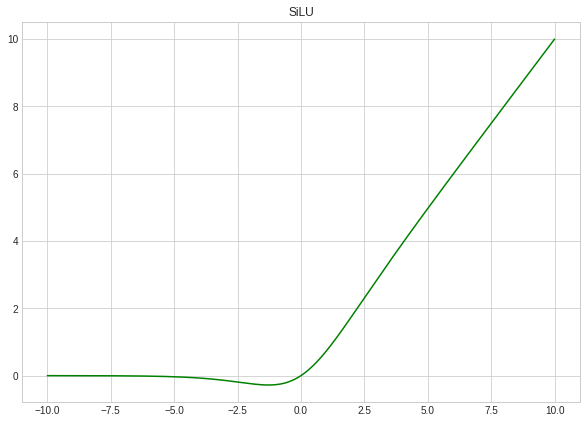

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("SiLU")

x = np.linspace(-10, 10, 1000)
ax.plot(x, x * sigmoid(x), '-g');

The implementation of SiLU:

In [6]:
# simply define a silu function
def silu(input):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:

        SiLU(x) = x * sigmoid(x)
    '''
    return input * torch.sigmoid(input) # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class SiLU(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
    
        SiLU(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf

    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        return silu(input) # simply apply already implemented SiLU

Now it's time for a small demo _(don't forget to enable GPU in kernel settings to make training faster)_

Here is a small example of building a model with nn.Sequential and out custom SiLU class:

In [7]:
# use SiLU with model created with Sequential

# initialize activation function
activation_function = SiLU()

# Initialize the model using nn.Sequential
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(784, 256)),
                      ('activation1', activation_function), # use SiLU
                      ('fc2', nn.Linear(256, 128)),
                      ('bn2', nn.BatchNorm1d(num_features=128)),
                      ('activation2', activation_function), # use SiLU
                      ('dropout', nn.Dropout(0.3)),
                      ('fc3', nn.Linear(128, 64)),
                      ('bn3', nn.BatchNorm1d(num_features=64)),
                      ('activation3', activation_function), # use SiLU
                      ('logits', nn.Linear(64, 10)),
                      ('logsoftmax', nn.LogSoftmax(dim=1))]))

# Run training
train_model(model)

Training the model. Make sure that loss decreases after each epoch.

Training loss: 478.8589185029268
Training loss: 350.0746013522148
Training loss: 319.25493428111076
Training loss: 294.4485657066107
Training loss: 280.9470457062125


We can also use silu function in model class as follows:

In [8]:
# create class for basic fully-connected deep neural network
class ClassifierSiLU(nn.Module):
    '''
    Demo classifier model class to demonstrate SiLU
    '''
    def __init__(self):
        super().__init__()

        # initialize layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        # apply silu function
        x = silu(self.fc1(x))

        # apply silu function
        x = silu(self.fc2(x))
        
        # apply silu function
        x = silu(self.fc3(x))
        
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# Create demo model
model = ClassifierSiLU()
    
# Run training
train_model(model)

Training the model. Make sure that loss decreases after each epoch.

Training loss: 466.8241208344698
Training loss: 349.4934533312917
Training loss: 313.43123760819435
Training loss: 293.65521355718374
Training loss: 279.42011239379644


## Implement Activation Function with Learnable Parameters

There are lot's of activation functions with parameters, which can be trained with gradient descent while training the model. A great example for one of these is [SoftExponential](https://arxiv.org/pdf/1602.01321.pdf) function:

$$SoftExponential(x, \alpha) = \left\{\begin{matrix} - \frac{log(1 - \alpha(x + \alpha))}{\alpha}, \alpha < 0\\  x, \alpha = 0\\  \frac{e^{\alpha * x} - 1}{\alpha} + \alpha, \alpha > 0 \end{matrix}\right.$$

Plot (image from wikipedia):

![soft exponential plot](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Activation_soft_exponential.svg/2880px-Activation_soft_exponential.svg.png)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  


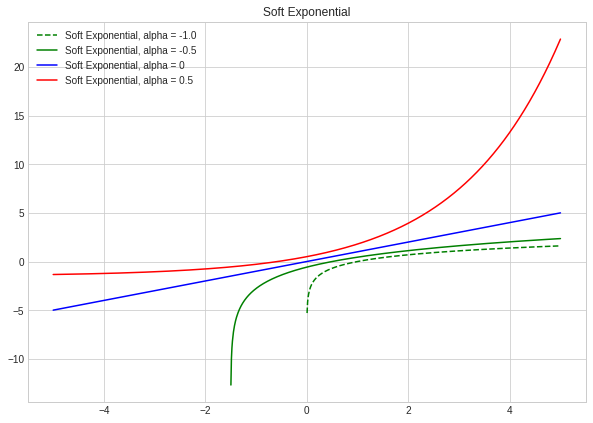

In [9]:
# Soft Exponential
def soft_exponential_func(x, alpha):
    if alpha == 0.0:
        return x
    if alpha < 0.0:
        return - np.log(1 - alpha * (x + alpha)) / alpha
    if alpha > 0.0:
        return (np.exp(alpha * x) - 1)/ alpha + alpha

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("Soft Exponential")

x = np.linspace(-5, 5, 1000)
ax.plot(x, soft_exponential_func(x, -1.0), '-g', label = 'Soft Exponential, alpha = -1.0', linestyle = 'dashed');
ax.plot(x, soft_exponential_func(x, -0.5), '-g', label = 'Soft Exponential, alpha = -0.5');
ax.plot(x, soft_exponential_func(x, 0), '-b', label = 'Soft Exponential, alpha = 0');
ax.plot(x, soft_exponential_func(x, 0.5), '-r', label = 'Soft Exponential, alpha = 0.5');

plt.legend();

To implement an activation function with trainable parameters we have to:
* derive a class from nn.Module and make alpha one of its members,
* wrap alpha as a Parameter and set requiresGrad to True.

See an example:

In [10]:
class soft_exponential(nn.Module):
    '''
    Implementation of soft exponential activation.

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Parameters:
        - alpha - trainable parameter

    References:
        - See related paper:
        https://arxiv.org/pdf/1602.01321.pdf

    Examples:
        >>> a1 = soft_exponential(256)
        >>> x = torch.randn(256)
        >>> x = a1(x)
    '''
    def __init__(self, in_features, alpha = None):
        '''
        Initialization.
        INPUT:
            - in_features: shape of the input
            - aplha: trainable parameter
            aplha is initialized with zero value by default
        '''
        super(soft_exponential,self).__init__()
        self.in_features = in_features

        # initialize alpha
        if alpha == None:
            self.alpha = Parameter(torch.tensor(0.0)) # create a tensor out of alpha
        else:
            self.alpha = Parameter(torch.tensor(alpha)) # create a tensor out of alpha
            
        self.alpha.requiresGrad = True # set requiresGrad to true!

    def forward(self, x):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        if (self.alpha == 0.0):
            return x

        if (self.alpha < 0.0):
            return - torch.log(1 - self.alpha * (x + self.alpha)) / self.alpha

        if (self.alpha > 0.0):
            return (torch.exp(self.alpha * x) - 1)/ self.alpha + self.alpha

Let's make a small demo: create a simple model, which uses Soft Exponential activation:

In [11]:
# create class for basic fully-connected deep neural network
class ClassifierSExp(nn.Module):
    '''
    Basic fully-connected network to test Soft Exponential activation.
    '''
    def __init__(self):
        super().__init__()

        # initialize layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # initialize Soft Exponential activation
        self.a1 = soft_exponential(256)
        self.a2 = soft_exponential(128)
        self.a3 = soft_exponential(64)

    def forward(self, x):
        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        # apply Soft Exponential unit
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.a3(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x
    
model = ClassifierSExp()
train_model(model)

Training the model. Make sure that loss decreases after each epoch.

Training loss: 558.482414022088
Training loss: 472.3926571011543
Training loss: 453.55578088760376
Training loss: 438.11303447186947
Training loss: 430.5142505913973


## Implement Activation Function with Custom Backward Step
The perfect example of an activation function, which needs implementation of a custom backward step is [BReLU](https://arxiv.org/pdf/1709.04054.pdf) (Bipolar Rectified Linear Activation Unit):

$$BReLU(x_i) = \left\{\begin{matrix} f(x_i), i \mod 2 = 0\\  - f(-x_i), i \mod 2 \neq  0 \end{matrix}\right.$$

This function is not differenciable at 0, so automatic gradient computation may fail.

Plot:

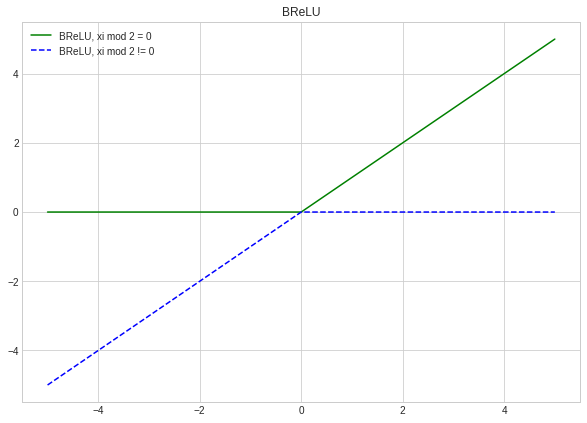

In [12]:
# ReLU function
def relu(x):
    return (x >= 0) * x
# inversed ReLU
def inv_relu(x):
    return - relu(- x)

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title("BReLU")

x = np.linspace(-5, 5, 1000)
ax.plot(x, relu(x), '-g', label = 'BReLU, xi mod 2 = 0');
ax.plot(x, inv_relu(x), '-b', label = 'BReLU, xi mod 2 != 0', linestyle='dashed');

plt.legend();

To impement custom activation function with backward step we should:
* create a class which, inherits Function from torch.autograd,
* override static forward and backward methods. Forward method just applies the function to the input. Backward method should compute the gradient of the loss function with respect to the input given the gradient of the loss function with respect to the output.

Let's see an example for BReLU:

In [13]:
class brelu(Function):
    '''
    Implementation of BReLU activation function.

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        - See BReLU paper:
        https://arxiv.org/pdf/1709.04054.pdf

    Examples:
        >>> brelu_activation = brelu.apply
        >>> t = torch.randn((5,5), dtype=torch.float, requires_grad = True)
        >>> t = brelu_activation(t)
    '''
    #both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input) # save input for backward pass

        # get lists of odd and even indices
        input_shape = input.shape[0]
        even_indices = [i for i in range(0, input_shape, 2)]
        odd_indices = [i for i in range(1, input_shape, 2)]

        # clone the input tensor
        output = input.clone()

        # apply ReLU to elements where i mod 2 == 0
        output[even_indices] = output[even_indices].clamp(min=0)

        # apply inversed ReLU to inversed elements where i mod 2 != 0
        output[odd_indices] = 0 - output[odd_indices] # reverse elements with odd indices
        output[odd_indices] = - output[odd_indices].clamp(min = 0) # apply reversed ReLU

        return output

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        grad_input = None # set output to None

        input, = ctx.saved_tensors # restore input from context

        # check that input requires grad
        # if not requires grad we will return None to speed up computation
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.clone()

            # get lists of odd and even indices
            input_shape = input.shape[0]
            even_indices = [i for i in range(0, input_shape, 2)]
            odd_indices = [i for i in range(1, input_shape, 2)]

            # set grad_input for even_indices
            grad_input[even_indices] = (input[even_indices] >= 0).float() * grad_input[even_indices]

            # set grad_input for odd_indices
            grad_input[odd_indices] = (input[odd_indices] < 0).float() * grad_input[odd_indices]

        return grad_input

Create a simple classifier model for a demonstration and run training:[](http://)

In [14]:
class ClassifierBReLU(nn.Module):
    '''
    Simple fully-connected classifier model to demonstrate BReLU activation.
    '''
    def __init__(self):
        super(ClassifierBReLU, self).__init__()

        # initialize layers
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # create shortcuts for BReLU
        self.a1 = brelu.apply
        self.a2 = brelu.apply
        self.a3 = brelu.apply

    def forward(self, x):
        # make sure the input tensor is flattened
        x = x.view(x.shape[0], -1)

        # apply BReLU
        x = self.a1(self.fc1(x))
        x = self.a2(self.fc2(x))
        x = self.a3(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x
    
model = ClassifierBReLU()
train_model(model)

Training the model. Make sure that loss decreases after each epoch.

Training loss: 585.9589667767286
Training loss: 442.55006262660027
Training loss: 414.7568979859352
Training loss: 390.45185139775276
Training loss: 372.7816904038191


## Conclusion
In this tutorial I demonstrated:
* How to create a simple custom activation function,
* How to create an activation function with learnable parameters, which can be trained using gradient descent,
* How to create an activation function with custom backward step.

## Improvement
While building a lot of custom activation functions, I noticed, that they often consume much more GPU memory. Creation of inplace implementations of custom activations using PyTorch inplace methods will improve this situation.

## Additional References
Links to the additional resources and further reading:
1. [Activation functions wiki page](https://en.wikipedia.org/wiki/Activation_function)
2. [Tutorial on extending PyTorch](https://pytorch.org/docs/master/notes/extending.html)
3. [Implementation of Maxout in PyTorch](https://github.com/Usama113/Maxout-PyTorch/blob/master/Maxout.ipynb)
4. [PyTorch Comprehensive Overview](https://medium.com/@layog/a-comprehensive-overview-of-pytorch-7f70b061963f)
5. [PyTorch and Fashion MNIST Kernel](https://www.kaggle.com/arturlacerda/pytorch-conditional-gan) I copied some code to load the data

## PS
![echo logo](https://github.com/Lexie88rus/Activation-functions-examples-pytorch/blob/master/assets/echo_logo.png?raw=true)

I participate in implementation of a __Echo package__ with mathematical backend for neural networks, which can be used with most popular existing packages (TensorFlow, Keras and [PyTorch](https://pytorch.org/)). We have done a lot for activation functions for PyTorch so far. Here is a [link to a repository on GitHub](https://github.com/digantamisra98/Echo/tree/Dev-adeis), __I will highly appreciate your feedback__ on that.